Learning outcomes

* Understand the effects of different types of qubit errors.
* Know how to perform simple quantum error correction to mitigate for bit- and phase-flip errors.

Codercise E.2.1 In her lab, Alice can initialize her two auxiliary qubits(on wires 1 and 2) to $\Ket{0}$, and she hopes to create a logical qubit that would help protect the message of her first qubit (wire 0). In other words, if her message is $\Ket{\psi} = a\Ket{0} + b\Ket{1}$, she wants to encode the message into the state $\Ket{\psi_l} = a\Ket{0_l} + b\Ket{1_l} = a\Ket{000} + b\Ket{111}$.

Once the qubits pass through the noisy communication channel and Bob receives them, he will have to decode the message, so that the first qubit (wire 0) again takes on the value Alice tried sending, $\Ket{\psi} = a\Ket{0} + b\Ket{1}$. In this case, we are assuming that either none of the qubits experienced a bit-flip error, or a maximum of one of them did.

In [2]:
import numpy as np
import pennylane as qml

In [9]:
dev = qml.device("default.mixed", wires=3)

@qml.qnode(dev)
def bitflip_code_expval(p):
    """A circuit that uses two auxiliary qubits to encode the message of the first qubit, puts them through a simple noisy channel with a chance of a bit-flip error occuring, then decodes it and measures the expectation value of the original message.

    Args:
        p (float): Probability of one bit-flip error occuring in the noisy channel for each wire.

    Returns:
        (float): Expectation value of the message qubit.
    """
    # Using two auxiliary qubits on wires 1 and 2, encode the message on wire 0 into a logical qubit
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[0,2])

    # Put all wires through a noisy channel, where each wire has a probability p that a bit-flip error will occur
    qml.BitFlip(p, wires=0)
    qml.BitFlip(p, wires=1)
    qml.BitFlip(p, wires=2)

    # Decode the message after the noisy channel
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[0,2])
    qml.Toffoli(wires=[2,1,0])

    # Measure the expectation value of the message
    return qml.expval(qml.PauliZ([0]))


In [4]:
bitflip_code_expval(0.2)

array(0.792)

**Codercise E.2.2** This time around Alice is sending her message to Bob through a noisy channel that has some small probability $p$ to cause a phase flip on each of the wires. Using the same setup as in the previous exercise, transform the logical qubits so we can correct for phase-flip errors using the structure of the three-qubit bit-flip code.

In [8]:
dev = qml.device("default.mixed", wires=3)

@qml.qnode(dev)
def phaseflip_code_expval(p):
    """A circuit that uses two auxiliary qubits to encode the message of the first qubit, puts them through a simple noisy channel with a chance of a bit-flip error occurring, then decodes it and measures the expectation value of the original message.

    Args:
        p (float): Probability of one bit-flip error occurring in the noisy channel for each wire.

    Returns:
        (float): Expectation value of the message qubit.
    """
    # Encode the message on wire 0 into a logical qubit, and transform it into the Hadamard basis
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[0,2])
    qml.broadcast(qml.Hadamard, wires=[0,1,2], pattern='single')

    # Transform the logical qubit into the Hadamard basis, put all wires through a noisy channel where each wire has a probability p that a phase-flip error will occur, then transform the result back into the computational basis.
    qml.PhaseFlip(p, wires=0)
    qml.PhaseFlip(p, wires=1)
    qml.PhaseFlip(p, wires=2)

    # Decode the message after the noisy channel and transform it back into the computational basis
    qml.broadcast(qml.Hadamard, wires=[0,1,2], pattern='single')
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[0,2])
    qml.Toffoli(wires=[2,1,0])


    # Measure the expectation value of the message
    return qml.expval(qml.PauliZ([0]))

**Codercise E.2.3**
For example, let's take a closer look at the expectation value of the message - in a bit-flip noisy channel, what is the largest error probability $p$ that will still leave our expectation value larger than 0.9?

In [12]:
# Range of bit-flip error probability
probability_range = np.arange(0.0, 0.5, 0.01)
# Initialize the array of function values
expvals = []
# Calculate function values for the circuit and append them to the list
for prob in probability_range:
    expvals.append(bitflip_code_expval(prob))
expvals

[array(1.),
 array(0.999404),
 array(0.997632),
 array(0.994708),
 array(0.990656),
 array(0.9855),
 array(0.979264),
 array(0.971972),
 array(0.963648),
 array(0.954316),
 array(0.944),
 array(0.932724),
 array(0.920512),
 array(0.907388),
 array(0.893376),
 array(0.8785),
 array(0.862784),
 array(0.846252),
 array(0.828928),
 array(0.810836),
 array(0.792),
 array(0.772444),
 array(0.752192),
 array(0.731268),
 array(0.709696),
 array(0.6875),
 array(0.664704),
 array(0.641332),
 array(0.617408),
 array(0.592956),
 array(0.568),
 array(0.542564),
 array(0.516672),
 array(0.490348),
 array(0.463616),
 array(0.4365),
 array(0.409024),
 array(0.381212),
 array(0.353088),
 array(0.324676),
 array(0.296),
 array(0.267084),
 array(0.237952),
 array(0.208628),
 array(0.179136),
 array(0.1495),
 array(0.119744),
 array(0.089892),
 array(0.059968),
 array(0.029996)]

In [26]:
def largest_p():
    # Range of bit-flip error probability
    probability_range = np.arange(0.0, 0.5, 0.01)
    # Initialize the array of function values
    expvals = []
    # Calculate function values for the circuit and append them to the list
    for prob in probability_range:
        expvals.append(bitflip_code_expval(prob))

    # Find out what the largest p is for which the expectation value of the message stays above 0.9
    expvals_array = np.array(expvals)
    indexes = np.where(expvals_array > 0.9)[0]
    result = np.max(probability_range[indexes])

    return result

In [20]:
print(largest_p())

0.13


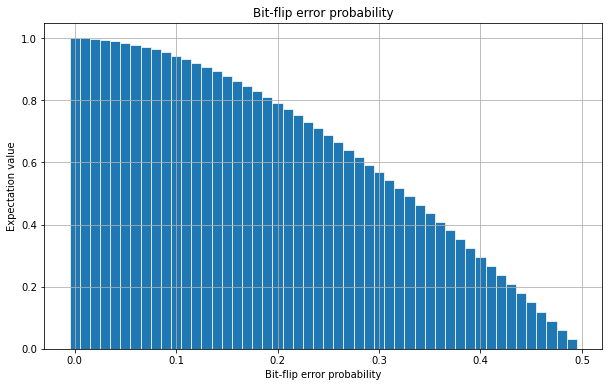

In [40]:
import matplotlib.pyplot as plt
probability_range = np.arange(0.0, 0.5, 0.01)
# Initialize the array of function values
expvals = []
# Calculate function values for the circuit and append them to the list
for prob in probability_range:
    expvals.append(bitflip_code_expval(prob))
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(probability_range, expvals, width=0.01, edgecolor="white", linewidth=0.7)
plt.title('Bit-flip error probability')
plt.xlabel('Bit-flip error probability')
plt.ylabel('Expectation value')
plt.grid(True)
plt.show()

**Codercise E.2.4** As a final step in your coding introduction to quantum error correction, we are asking you to put Alice's message through a noisy channel that has $n$ opportunities to apply a bit-flip error (with the probability $p$) to each of the wires.

In other words, put the logical qubit through a bit-flip noisy channel $n$ times in a row and see what happens to the largest error probability from which we can still protect our message

In [30]:
n = 3
dev = qml.device("default.mixed", wires=3)

@qml.qnode(dev)
def multi_bitflip_code_expval(p, n):
    """A circuit that uses two auxiliary qubits to encode the message of the first qubit, puts them through a noisy channel with three opportunities for a bit-flip error occuring on each of the wires, then decodes it and measures the expectation value of the original message.

    Args:
        p (float): Probability of one bit-flip error occuring in the noisy channel for each wire.

    Returns:
        (float): Expectation value of the message qubit.
    """
    # Using two auxiliary qubits on wires 1 and 2, encode the message on wire 0 into a logical qubit
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[0,2])

    # Put all wires through a noisy channel, where each wire has a probability p that a bit-flip error will occur
    # This probability occurs three times in a row
    for i in range(3):
        qml.BitFlip(p, wires=0)
        qml.BitFlip(p, wires=1)
        qml.BitFlip(p, wires=2)

    # Decode the message after the noisy channel
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[0,2])
    qml.Toffoli(wires=[1,2,0])

    # Measure the expectation value of the message
    return qml.expval(qml.PauliZ([0]))

In [34]:
    probability_range = np.arange(0.0, 0.5, 0.01)
    expvals = [multi_bitflip_code_expval(probability, n) for probability in  probability_range]
    expvals

[array(1.),
 array(0.99491412),
 array(0.980837),
 array(0.9593786),
 array(0.93195132),
 array(0.89978976),
 array(0.86396881),
 array(0.82542029),
 array(0.78494813),
 array(0.74324222),
 array(0.70089114),
 array(0.65839354),
 array(0.61616868),
 array(0.57456579),
 array(0.53387265),
 array(0.4943232),
 array(0.45610445),
 array(0.41936266),
 array(0.3842088),
 array(0.35072346),
 array(0.31896115),
 array(0.28895417),
 array(0.26071592),
 array(0.23424385),
 array(0.20952205),
 array(0.18652344),
 array(0.1652117),
 array(0.1455429),
 array(0.12746694),
 array(0.11092866),
 array(0.09586893),
 array(0.08222539),
 array(0.06993322),
 array(0.05892564),
 array(0.04913441),
 array(0.04049016),
 array(0.03292271),
 array(0.02636129),
 array(0.02073468),
 array(0.0159714),
 array(0.01199974),
 array(0.0087479),
 array(0.00614397),
 array(0.00411599),
 array(0.002592),
 array(0.0015),
 array(0.000768),
 array(0.000324),
 array(9.59999999e-05),
 array(1.2e-05)]

In [35]:
import matplotlib.pyplot as plt

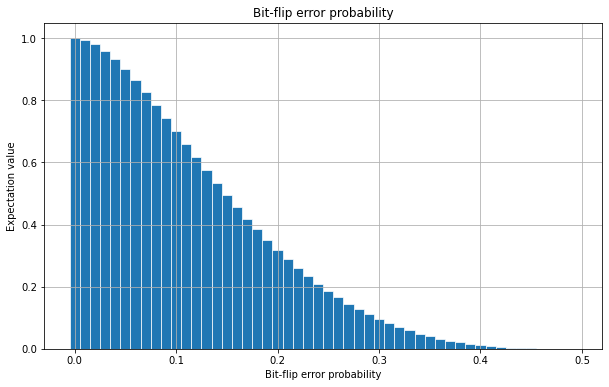

In [39]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(probability_range, expvals, width=0.01, edgecolor="white", linewidth=0.7)
plt.title('Bit-flip error probability')
plt.xlabel('Bit-flip error probability')
plt.ylabel('Expectation value')
plt.grid(True)
plt.show()